# Object Recognition and Explanation

**Model Goal**: to recognize, after a training phase with a dataset of images containing numbers, the numbers that are depicted. In a second phase, it must be able to recognize if the image does not contain numbers and/or objects, it must be able to understand the text depicted inside the image. 
Last phase: creation of a prompt to communicate with the model, to be able to provide context to the images, and to be able to ask questions.

## Number Identification using CNN

I'm referring to this online notebook for the number identification part: kaggle.com/code/arunrk7/digit-recognition-using-cnn-99-accuracy/notebook

In [19]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [20]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as img
%matplotlib inline

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

# setting theme of the data visualizer
sns.set(style="dark",context="notebook",palette="muted")

### Preparing Dataset

Data is provided by **MNIST Handwritten Digit Recognition competition** (kaggle.com/competitions/digit-recognizer).

- ```train.csv``` **contains both the images of the numbers** (in the form of pixels) and **the labels corresponding to the numbers (from 0 to 9)**.
- ```test.csv``` **contains only the images of the numbers**, without the labels (which must be provided by our model).

In [22]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

```Y_train``` will contain the number labels: this "label" column represents the numeric values ​​(0-9) associated with each image in the training dataset.

We remove the label column from the training dataset, creating ```X_train``` which **will contain only the image data in pixel form (without the labels)**. Each image is represented by a row in the dataset, and each column (except "label") represents a pixel.

label
1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: count, dtype: int64

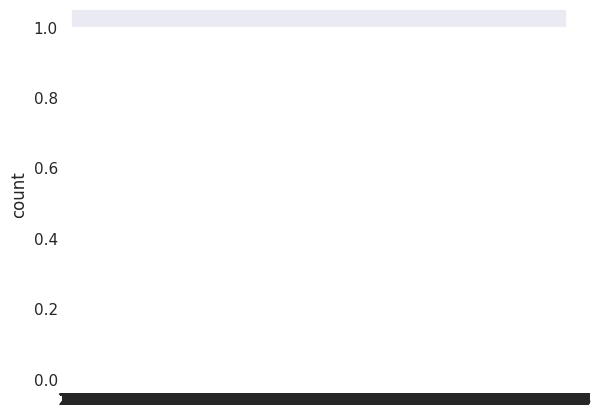

In [23]:
Y_train = train['label']

# dropping Label Column
X_train = train.drop(labels=['label'],axis=1)

# free up some space
del train

graph = sns.countplot(Y_train)
 
Y_train.value_counts()

```sns.countplot(Y_train)``` creates a bar chart showing the distribution of number labels in the training dataset. In other words, it shows how many images there are for each number (from 0 to 9).

So: 

- ```Y_train``` contains labels corresponding to actual numbers in the images. Each value in Y_train represents the number (0 to 9) depicted in an image.

- ```X_train``` contains only the image data (without labels), where each row represents an image and each column represents the value of a single pixel. The images in the dataset are in flattened format (a single vector of pixels) and no longer contain labels after running the drop() command.

If ```Y_train[0]``` == 3, then the first image of X_train represents the number "3".
```X_train[0]``` represents the pixel values ​​that form the image of the number 3.

### Normalization and Reshaping

The pixel value ranges from 0 to 255 which specify gradient of gray. The CNN will converge more faster on values 0 to 1 than 0 to 255. So **we divide every value by 255 to scale the data from [0..255] to [0..1]**. It helps the model to better learning of features by decreasing computational complexities if we have data that scales bigger.

In [24]:
X_train = X_train/255
test = test/255

The array of pixel values are **reshaped into a (28, 28, 1) matrix**. We are feeding the CNN model with input_shape of 28 x 28 x 1 matrix.

In [25]:
X_train = X_train.values.reshape(-1,28,28,1)
test = test.values.reshape(-1,28,28,1)

The ```reshape()``` function is used to **reorganize the image pixel array from a flat (1D vector) format into a more natural format** for processing by CNNs. 

- **Before reshaping**: Images in the dataset are represented as 1D vectors of pixels. For a dataset like MNIST, which has **28x28 pixel images**, **each image is initially flattened into an array of 784 pixel values ​​(i.e. 28 * 28 = 784)**. In other words, **each image is a row with 784 columns representing individual pixel values**.

- **After reshaping**: With ```X_train.values.reshape(-1, 28, 28, 1)```, **we are rearranging each 784 pixel vector into a 28x28 matrix with an additional channel**, represented by 1 at the end. **This creates an array of shape (28, 28, 1), which corresponds to the structure of the original image: 28x28 is the resolution of the image, and 1 indicates that the image has only one channel (in this case, it is a grayscale)**.

In [26]:
Y_train = tf.keras.utils.to_categorical(Y_train, num_classes=10)

Then, we convert labels into a format called **"one-hot encoding"**: **it transforms the labels (which are integers, such as 0, 1, 2, ... 9 in the case of digit recognition) into binary vectors called one-hot vectors**. **Each numeric label is represented as a vector of length equal to the number of classes** (in this case 10, for the digits from 0 to 9).

For example: if the label is 7, the one-hot vector will be: ```[0, 0, 0, 0, 0, 0, 0, 1, 0, 0]```

Many deep learning models, including those based on Keras or TensorFlow, expect labels to be in one-hot format during the training phase.

Example of use in the context of digit recognition (MNIST): suppose our label dataset Y_train contains the digits 0 to 9. Without one-hot encoding, Y_train would have values ​​like:

```Y_train = [0, 7, 1, 4, 9, ...]```

After applying to_categorical(), each label will be converted into a one-hot vector:

```
Y_train = [
  [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],  # represents "0"
  [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],  # represents "7"
  [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],  # represents "1"
  [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],  # represents "4"
  ...
]
```

### Train and Validation Data Split

We are now **segmenting the input data for training into two exclusive data namely, Train and Validation datasets**. **Train data is used to train the model, whereas the validation data is used for cross verification of the model's accuracy and how well the model is generalized for the data other than training data**.

Validation accuracy and loss will tell us the performance of the model for new data and it will show if there is overfitting or underfitting situation while model training.

In [27]:
# splitting Train and test set
random_seed=2

X_train,X_val,Y_train,Y_val = train_test_split(X_train,Y_train,test_size=0.1,
                                                random_state = random_seed)

- ```X_train``` and ```Y_train```: These contain the **images (data) and labels for training the model respectively**.
- ```X_val``` and ```Y_val```: These contain **the images and labels for validation**. During training, the model will be evaluated on this set to see how it performs on data it has never seen before, giving an indication of how it might generalize to new data.

```test_size=0.1``` means that **10% of the original data will be used as the validation set**, **while the remaining 90% will be used for training**.

The random seed makes sure that the dataset will be splitted in the same way at every code execution.

### Model 

CNN uses convolutional layers to extract image features and reduce dimensionality through pooling. The fully connected layers finally do classification based on the extracted features, and techniques like **ReLU (nonlinear activation)** and **Dropout (overfitting prevention)** help improve the accuracy and generalization of the model.

The CNN has the following structure:

**Input → [[Conv2D → ReLU] * 2 → MaxPool2D → Dropout] * 2 → Flatten → Dense → Dropout → Output**

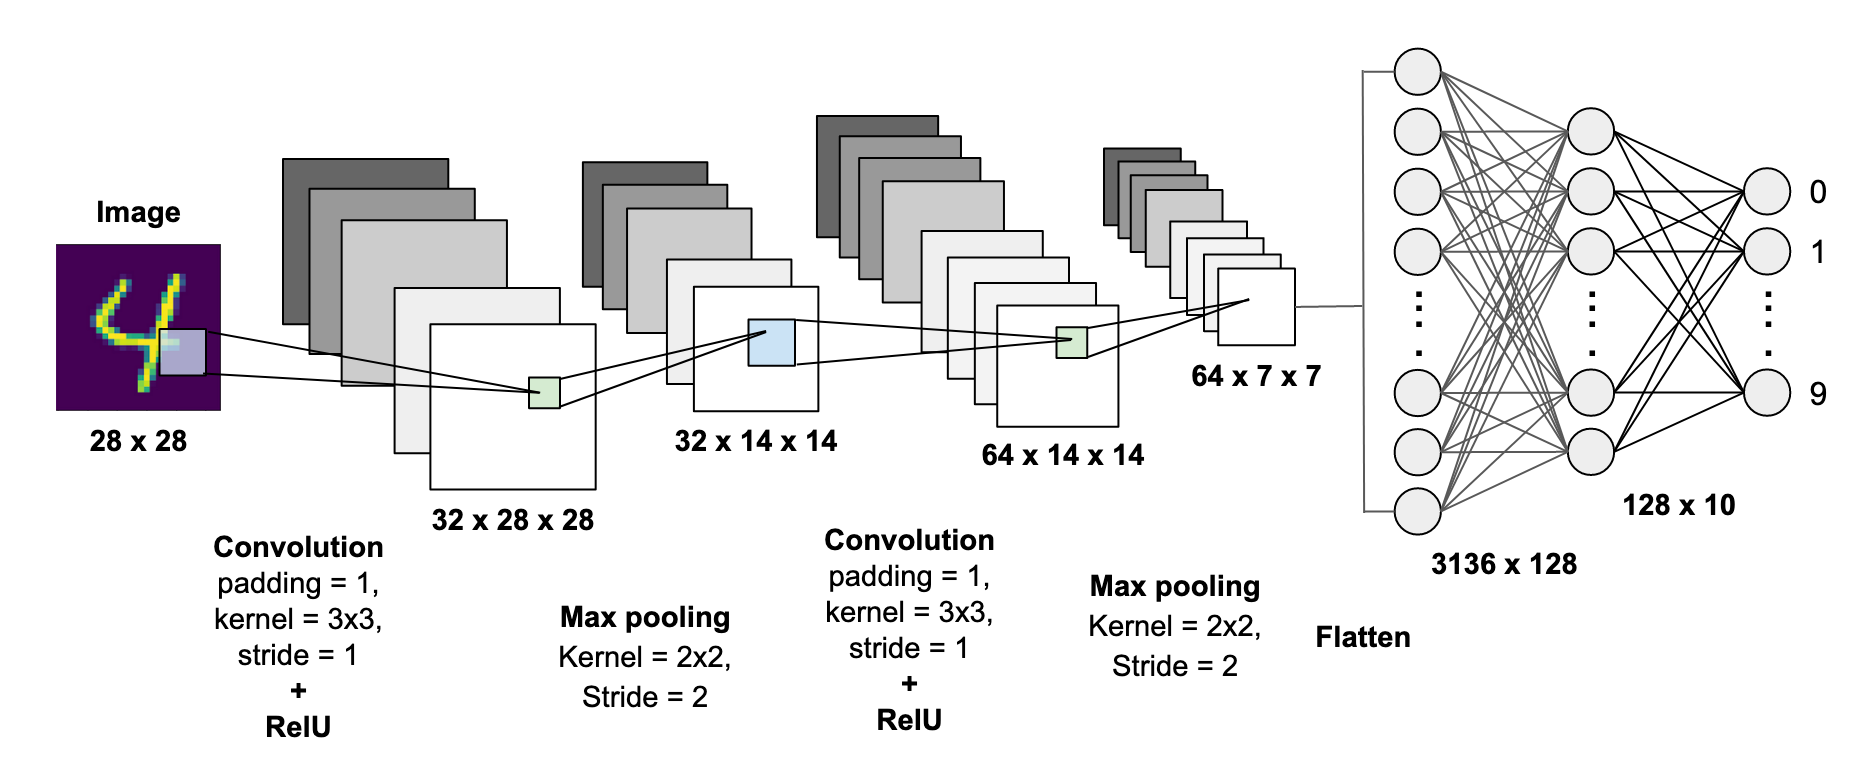

In [28]:
model = tf.keras.Sequential()

#### First Convolutional Block

1. **Conv2D**. It applies a 2D convolution with 32 filters, each of which is 5x5 in size. 
    - ```padding='Same'``` means that **the edges of the image are padded** so that the output of the convolution has the same size as the input.
    - ```activation=tf.nn.relu```: Uses **the ReLU (Rectified Linear Unit) activation function** to introduce nonlinearity.
    - ```input_shape=(28,28,1)```: Specifies the size of the input, in this case 28x28 pixel images with a single channel (grayscale images).

In [29]:
model.add(layers.Conv2D(filters=32, kernel_size=(5,5), padding='Same', 
                       activation=tf.nn.relu, input_shape = (28,28,1)))

/home/pierluigi/Documents/virtual_ambients/objectdet/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1727106009.095385     513 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-09-23 17:40:09.096589: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2343] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and set

2. **Second convolutional block**: another convolution with the same parameters (32 5x5 filters) and ReLU activation. It is common to stack multiple convolutional layers before reducing the dimensionality with a MaxPooling.

In [31]:
model.add(layers.Conv2D(filters=32, kernel_size=(5,5), padding='Same', activation=tf.nn.relu))

3. **MaxPool2D**: Reduces the spatial dimension (width and height) of the output by taking the maximum value in each 2x2 window. This reduces model complexity and increases efficiency by reducing overfitting.

In [32]:
model.add(layers.MaxPool2D(pool_size=(2,2)))

4. **Dropout(0.25)**: Randomly turns off 25% of the neurons in this layer during training to prevent overfitting. Improves the generalization ability of the model.

In [33]:
model.add(layers.Dropout(0.25))

#### Second Convolutional Block

1. **Two convolutional layers with 64 filters of size 3x3 each, and ReLU activation**. Increasing the number of filters (from 32 to 64) allows learning more complex features from images.

In [34]:
model.add(layers.Conv2D(filters=64, kernel_size=(3,3), padding='Same', activation=tf.nn.relu))
model.add(layers.Conv2D(filters=64, kernel_size=(3,3), padding='Same', activation=tf.nn.relu))

2. **Another layer of max pooling with a 2x2 window**. This further reduces the spatial dimension of the image, helping to reduce model complexity.

In [35]:
model.add(layers.MaxPool2D(pool_size=(2,2),strides=(2,2)))

3. **Reapply a 25% Dropout to prevent overfitting**.

In [36]:
model.add(layers.Dropout(0.25))

#### Flatten Layer

It flattens the output of the convolutional layers into a 1D vector, so that it can be used as input for the fully connected (Dense) layers.

In [37]:
model.add(layers.Flatten())

#### Dense layer (fully connected)

Fully connected layer with 256 neurons, with ReLU activation. Here the model learns complex relationships between features learned from previous convolutions, plus another Dropout layer for preventing overfitting. 

In [38]:
model.add(layers.Dense(256, activation=tf.nn.relu))

In [39]:
model.add(layers.Dropout(0.25))

#### Output Layer 

In [40]:
model.add(layers.Dense(10, activation=tf.nn.softmax))